# Init

In [ ]:
%%capture
import importlib
from cycler import cycler
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')
sys.path.insert(0, 'bandstructure')

import caustic_frame
importlib.reload(caustic_frame)

import caustic_bandstructure
importlib.reload(caustic_bandstructure)

from delafossite_bandstructure import delafossite

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

# Generate frame

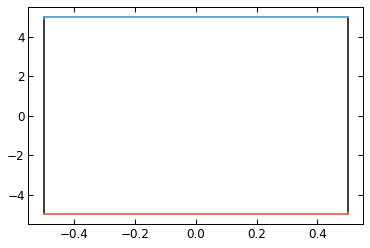

In [2]:
frame = caustic_frame.Frame('geo/bar.dxf')
frame.gen_fig();

In [3]:
frame.edges

[([(-0.5, 5.0), (0.5, 5.0)], 2),
 ([(0.5, 5.0), (0.5, 4.9)], 2),
 ([(0.5, 4.9), (0.5, -4.9)], 0),
 ([(0.5, -4.9), (0.5, -5.0)], 1),
 ([(0.5, -5.0), (-0.5, -5.0)], 1),
 ([(-0.5, -5.0), (-0.5, -4.9)], 1),
 ([(-0.5, -4.9), (-0.5, 4.9)], 0),
 ([(-0.5, 4.9), (-0.5, 5.0)], 2)]

In [4]:
frame.edges[0][0][0][1]

5.0

In [5]:
for edge in frame.edges:
    print(edge[0])

[(-0.5, 5.0), (0.5, 5.0)]
[(0.5, 5.0), (0.5, 4.9)]
[(0.5, 4.9), (0.5, -4.9)]
[(0.5, -4.9), (0.5, -5.0)]
[(0.5, -5.0), (-0.5, -5.0)]
[(-0.5, -5.0), (-0.5, -4.9)]
[(-0.5, -4.9), (-0.5, 4.9)]
[(-0.5, 4.9), (-0.5, 5.0)]


In [6]:
frame.edgenorms

[-1.5707963267948966,
 -3.141592653589793,
 -3.141592653589793,
 -3.141592653589793,
 1.5707963267948966,
 0.0,
 0.0,
 0.0]

# Bandstructure

In [7]:
k = delafossite()
bs = caustic_bandstructure.Bandstructure(k, 0, 10)

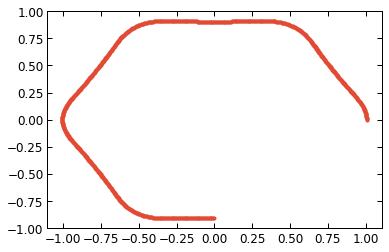

In [8]:
plt.figure()
plt.plot(bs.k[0][:750], bs.k[1][:750], '.')

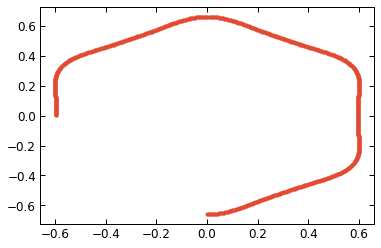

In [9]:
plt.figure()
plt.plot(bs.r[0][:750], bs.r[1][:750], '.')

In [10]:
k = delafossite()
bs = caustic_bandstructure.Bandstructure(k, 0, -10)

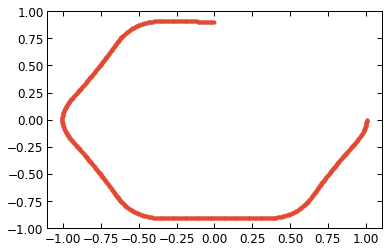

In [11]:
plt.figure()
plt.plot(bs.k[0][:750], bs.k[1][:750], '.')

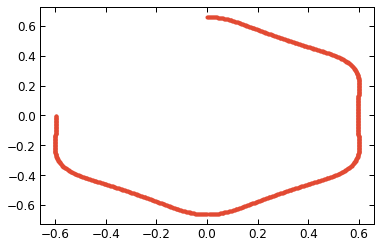

In [12]:
plt.figure()
plt.plot(bs.r[0][:750], bs.r[1][:750], '.')

In [13]:
frame.edges

[([(-0.5, 5.0), (0.5, 5.0)], 2),
 ([(0.5, 5.0), (0.5, 4.9)], 2),
 ([(0.5, 4.9), (0.5, -4.9)], 0),
 ([(0.5, -4.9), (0.5, -5.0)], 1),
 ([(0.5, -5.0), (-0.5, -5.0)], 1),
 ([(-0.5, -5.0), (-0.5, -4.9)], 1),
 ([(-0.5, -4.9), (-0.5, 4.9)], 0),
 ([(-0.5, 4.9), (-0.5, 5.0)], 2)]

In [14]:
frame.edgenorms

[-1.5707963267948966,
 -3.141592653589793,
 -3.141592653589793,
 -3.141592653589793,
 1.5707963267948966,
 0.0,
 0.0,
 0.0]

In [15]:
bs.calculate_injection_probs(frame.edgenorms)

In [16]:
bs.in_prob.keys()

dict_keys([0.0, 1.5707963267948966, -3.141592653589793, -1.5707963267948966])

In [17]:
np.cumsum(bs.in_prob[0])

array([0.00332534, 0.00664899, 0.00996933, 0.01328478, 0.01659379,
       0.01989488, 0.02318665, 0.02646776, 0.02973698, 0.03299317,
       0.0362353 , 0.03946244, 0.04267381, 0.04586869, 0.04904651,
       0.05220681, 0.05534923, 0.05847353, 0.06157955, 0.06466726,
       0.0677367 , 0.07078801, 0.07382141, 0.07683719, 0.0798352 ,
       0.08281604, 0.08578065, 0.0887296 , 0.09166349, 0.09458299,
       0.09748879, 0.10038162, 0.10326225, 0.10613145, 0.10899003,
       0.11183882, 0.11467864, 0.11751033, 0.12033474, 0.1231527 ,
       0.12596506, 0.12877263, 0.13157622, 0.13437664, 0.13717463,
       0.13997095, 0.1427663 , 0.14556135, 0.14835674, 0.15115305,
       0.15395083, 0.15675058, 0.15955274, 0.1623577 , 0.1651658 ,
       0.16797733, 0.17079253, 0.17361158, 0.1764346 , 0.17926167,
       0.18209282, 0.18492805, 0.1877673 , 0.19061046, 0.19345743,
       0.19630803, 0.19916209, 0.20201939, 0.20487973, 0.20774295,
       0.21060876, 0.21347684, 0.21634695, 0.21921885, 0.22209

0.0
1.5707963267948966
-3.141592653589793
-1.5707963267948966


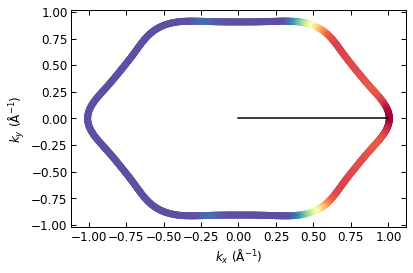

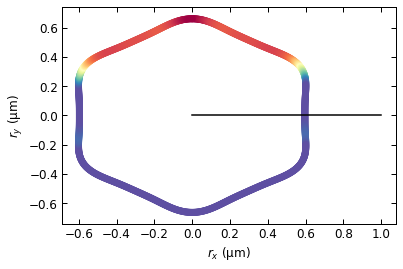

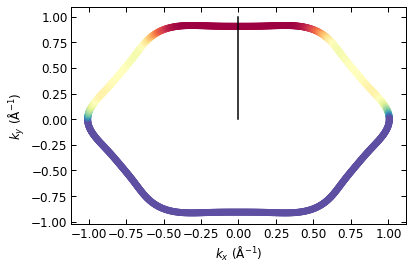

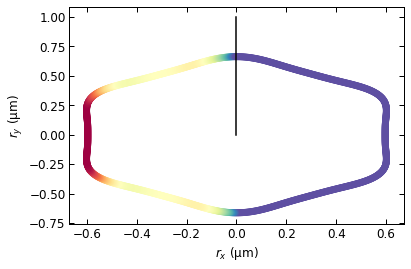

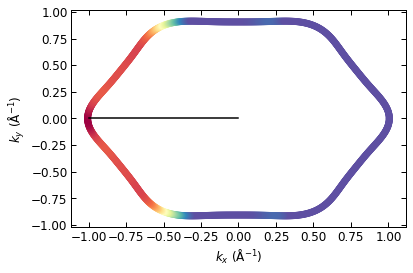

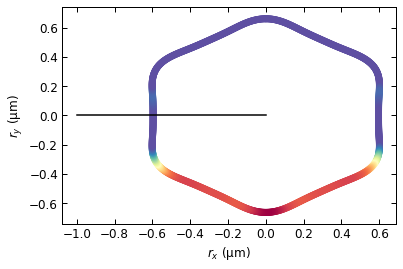

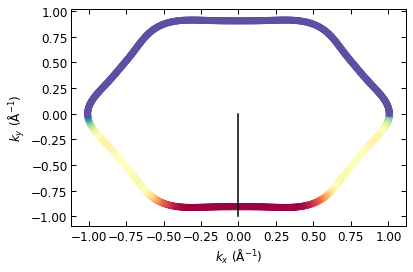

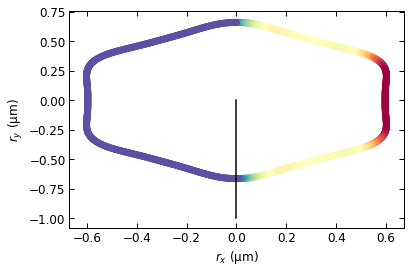

In [18]:
cmap = plt.get_cmap('Spectral_r')

for key in bs.in_prob.keys():
    print(key)
    max_p = np.max(bs.in_prob[key])
    colors = np.array([cmap(p/max_p) for p in bs.in_prob[key]])
    colors = np.append(colors, [colors[0]], axis=0)
    
    fig = plt.figure()
    plt.scatter(bs.k[0], bs.k[1],c=colors)
    plt.plot((0, np.cos(key)), (0, np.sin(key)),'k')
    plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
    plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
    
    fig = plt.figure()
    plt.scatter(bs.r[0], bs.r[1],c=colors)
    plt.plot((0, np.cos(key)), (0, np.sin(key)),'k')
    plt.xlabel(r'$r_x\ (\mathrm{\mu m})$')
    plt.ylabel(r'$r_y\ (\mathrm{\mu m})$')

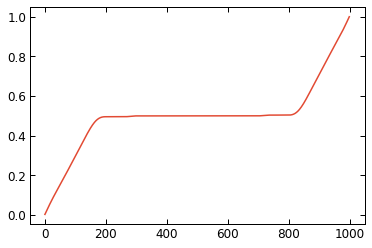

In [63]:
inds = []
n = 10000
freq = np.zeros(999)

for i in range(n):
    ind = bs.get_injection_index(0)
    inds.append(ind)
    freq[ind] += 1
    
prob = freq/n

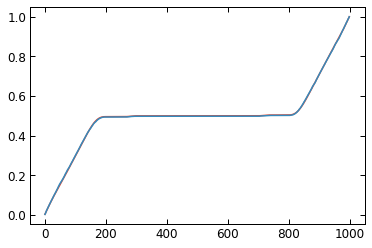

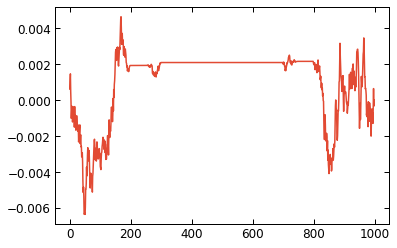

In [64]:
plt.figure()
plt.plot(bs.cum_prob[0])
plt.plot(np.cumsum(prob))

plt.figure()
plt.plot(bs.cum_prob[0]-np.cumsum(prob))